In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import ast

In [4]:
# Load CSV
df = pd.read_csv("../data/data.csv")

# Convert stringified list columns
df['genres'] = df['genres'].apply(ast.literal_eval)
df['privacy_types'] = df['privacy_types'].apply(ast.literal_eval)
df['data_categories'] = df['data_categories'].apply(ast.literal_eval)
df['data_types'] = df['data_types'].apply(ast.literal_eval)


In [5]:
# --- FEATURE ENCODING ---
# Base features
X_feats = pd.DataFrame()
X_feats['price'] = df['price']
X_feats['size'] = df['size']
X_feats['has_in_app_purchases'] = df['has_in_app_purchases'].astype(int)

# One-hot for country and rating
X_feats = pd.concat([
    X_feats,
    pd.get_dummies(df['country_code'], prefix='country'),
    pd.get_dummies(df['content_rating'], prefix='rating')
], axis=1)

In [6]:
# Multi-hot encode genres
mlb_genres = MultiLabelBinarizer()
genres = mlb_genres.fit_transform(df['genres'])
X_feats = pd.concat([X_feats, pd.DataFrame(genres, columns=[f"genre_{g}" for g in mlb_genres.classes_])], axis=1)

In [7]:
# --- LABELS ---
mlb_privacy = MultiLabelBinarizer()
mlb_categories = MultiLabelBinarizer()
mlb_types = MultiLabelBinarizer()

y_privacy = mlb_privacy.fit_transform(df['privacy_types'])
y_categories = mlb_categories.fit_transform(df['data_categories'])
y_types = mlb_types.fit_transform(df['data_types'])

In [8]:
# Combine Step 1 predicted outputs as inputs to Step 2
X_combined = np.concatenate([X_feats, y_privacy, y_categories], axis=1)
print("Combined input shape:", X_combined.shape)

# Normalize
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

Combined input shape: (10000, 83)


In [9]:
X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(y_types, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)


In [10]:
class DataTypePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=34):
        super(DataTypePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
model = DataTypePredictor(input_dim=X_combined.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

f1_scores = []

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            probs = torch.sigmoid(model(xb))
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_true.append(yb.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    f1 = f1_score(all_true, all_preds, average="micro")
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}: F1 Score = {f1:.4f}")


Epoch 1: F1 Score = 0.7150
Epoch 2: F1 Score = 0.7780
Epoch 3: F1 Score = 0.8097
Epoch 4: F1 Score = 0.8269
Epoch 5: F1 Score = 0.8319
Epoch 6: F1 Score = 0.8391
Epoch 7: F1 Score = 0.8404
Epoch 8: F1 Score = 0.8427
Epoch 9: F1 Score = 0.8416
Epoch 10: F1 Score = 0.8455
Epoch 11: F1 Score = 0.8429
Epoch 12: F1 Score = 0.8444
Epoch 13: F1 Score = 0.8435
Epoch 14: F1 Score = 0.8443
Epoch 15: F1 Score = 0.8467
Epoch 16: F1 Score = 0.8442
Epoch 17: F1 Score = 0.8451
Epoch 18: F1 Score = 0.8449
Epoch 19: F1 Score = 0.8444
Epoch 20: F1 Score = 0.8453
Epoch 21: F1 Score = 0.8461
Epoch 22: F1 Score = 0.8454
Epoch 23: F1 Score = 0.8475
Epoch 24: F1 Score = 0.8464
Epoch 25: F1 Score = 0.8477
Epoch 26: F1 Score = 0.8463
Epoch 27: F1 Score = 0.8464
Epoch 28: F1 Score = 0.8475
Epoch 29: F1 Score = 0.8462
Epoch 30: F1 Score = 0.8465
Epoch 31: F1 Score = 0.8467
Epoch 32: F1 Score = 0.8458
Epoch 33: F1 Score = 0.8475
Epoch 34: F1 Score = 0.8468
Epoch 35: F1 Score = 0.8470
Epoch 36: F1 Score = 0.8463
E

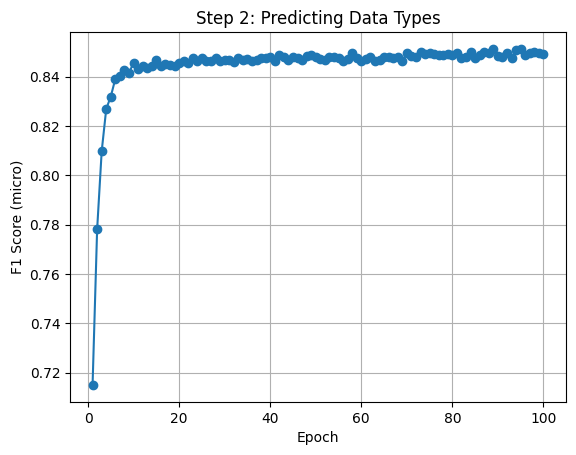

In [12]:
plt.plot(range(1, len(f1_scores)+1), f1_scores, marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (micro)")
plt.title("Step 2: Predicting Data Types")
plt.grid(True)
plt.show()


In [15]:
print(classification_report(
    all_true, all_preds, 
    target_names=mlb_types.classes_,
    zero_division=0
))


                         precision    recall  f1-score   support

       Advertising Data       0.74      0.82      0.77       594
             Audio Data       0.73      0.12      0.21        92
       Browsing History       1.00      1.00      1.00        38
        Coarse Location       0.85      0.95      0.90       534
               Contacts       1.00      1.00      1.00        75
             Crash Data       0.96      1.00      0.98      1168
            Credit Info       0.67      0.12      0.21        16
       Customer Support       0.74      0.83      0.78       385
              Device ID       0.88      0.98      0.93       988
          Email Address       0.94      1.00      0.97       601
Emails or Text Messages       0.40      0.04      0.06        57
   Environment Scanning       0.00      0.00      0.00         1
                Fitness       0.58      0.59      0.58        32
       Gameplay Content       0.56      0.39      0.46        97
                  Hands 